# Dataset inspection

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## Analysing and removing careless or biased participations

We created "Dummy tasks", randomly selected code components not affected by any of the code smells considered in our study. This was done to limit the bias in the study, i.e., avoid that participants always indicate that the code contains a problem.
So, we first look for participants that accomplish tasks in a careless and/or biased way, analysing how they performed tasks when faced with dummy tasks. For instance, we intentionally created a dummy task that defines a god class, however the correspondent java code have just few line of codes. Thus, we expected that the participant would mark "I strongly disagree" or, at minimun, "I Slightly disagree". After data inspection, we noted that almost all of the participant not behave biased ou carelessly. Except for 1 participant, all of them marks some degree of disagreement when evaluated dummy tasks.

In [123]:
headerParticipant = ["inviteId","codeRevision","codeSmellIdentification","degree","devExperience", "javaExperience","objOrientedExperience","origin","yearsDevExperience"]
headerAnswer = ["id","questionnaire_id","task_id","secondsToAnswer","isDt","answer_ptr_id","answer_csagreement","answer_description","answer_dtDescription"]
answer =  pd.read_csv('/mnt/d/Christiano/Documentos/dissertation/projeto/experiment/participant_answer.csv', header=None, escapechar="\\", encoding="latin_1")
answer.columns=headerParticipant+headerAnswer

dummy_id = "13,14,15,16"
answer_dummy = answer.query("task_id in ({0})".format(dummy_id))

# o questionnaire id 25 será retirado
#answer_dummy[answer_dummy.questionnaire_id==25].loc[:,'id':'answer_csagreement']

In [124]:
# retira as atividades dummy
answer_no_dummy = answer[~answer.id.isin(answer_dummy.id)]

# retira alguns participantes para equalizar o quadrado latino
answer_no_dummy_overall = answer_no_dummy[~answer_no_dummy.questionnaire_id.isin([50,68,55,25])]

# 12 participantes x 8 atividades = 96 rows
answer_no_dummy.head()

,inviteId,codeRevision,codeSmellIdentification,degree,devExperience,javaExperience,objOrientedExperience,origin,yearsDevExperience,id,questionnaire_id,task_id,secondsToAnswer,isDt,answer_ptr_id,answer_csagreement,answer_description,answer_dtDescription
0,0903fe3e42,2,1,B,2,3,2,A,2,102,16,3,119.14,1,102,2,The class is big and have too much code and va...,none
1,0903fe3e42,2,1,B,2,3,2,A,2,103,16,11,169.35,1,103,1,"It does have a long parameter list, could be a...","Helped me to see the number of statements, inp..."
2,0903fe3e42,2,1,B,2,3,2,A,2,104,16,7,250.75,1,104,1,The child class uses few methods from parent.,Helped me to identify why it was a refused beq...
3,0903fe3e42,2,1,B,2,3,2,A,2,105,16,4,235.66,1,105,-1,"It does too much in just one method, could be ...",helped me to identify where to search
7,0903fe3e42,2,1,B,2,3,2,A,2,110,16,8,42.01,0,110,2,The class is really long and implements too mu...,NaN


# Experiment results

In [13]:
import  statsmodels.stats.inter_rater as ir

def buildKappaTable(answer):    
    # calcula os agreements agrupando por atividade e agreement
    df_count_agreement = answer[['task_id','answer_csagreement']].groupby(['task_id','answer_csagreement']).size().reset_index(name='size')

    list_count_agreement = list()
    tasks = answer_no_dummy.task_id.unique()
    df_agreement_frame = pd.DataFrame([[-2,0],[-1,0],[1,0],[2,0]], columns=['answer_csagreement', 'size'])

    for task in tasks:
        df_tmp = df_count_agreement[df_count_agreement.task_id==task].iloc[:,1:3]
        df_merged = pd.merge_ordered(df_tmp, df_agreement_frame, fill_method='ffill', right_by="answer_csagreement", how="left")        
        list_count_agreement.append(df_merged['size'].tolist()) 
        
    # soma os agreements similares - agreement ou disagreement
    df_kappaTable = pd.DataFrame(list_count_agreement)
    df_disagree = df_kappaTable[0]+df_kappaTable[1]
    df_agree = df_kappaTable[2]+df_kappaTable[3]

    df_kappaTable = pd.concat([df_disagree, df_agree], axis=1)
    df_kappaTable.columns = ["Disagree", "Agree"]   
    df_kappaTable.index = tasks

    return df_kappaTable

def getFormattedTable(df_kappaTable):
    #relação de code smells e o código das atividades
    df_codeSmells = pd.DataFrame([[3,4,5,6,7,8,11,12],['gc','lm','rb','lm','rb','gc','lpl','lpl']])
    df_codeSmells = df_codeSmells.T
    df_codeSmells.columns = ['Task ID','CS']    
    df_kappaTable_formatted = pd.merge(df_kappaTable,df_codeSmells,left_index=True,right_on='Task ID')
    # reordena as colunas
    df_kappaTable_formatted = df_kappaTable_formatted[['Task ID','CS','Disagree','Agree']]
    #reordena as linhas por CS
    df_kappaTable_formatted = df_kappaTable_formatted.sort_values('CS')
    return df_kappaTable_formatted

def build(answer):
    answer_dt = answer[answer.isDt==1]
    answer_noDt = answer[answer.isDt==0]

    df_kappaTable_dt = buildKappaTable(answer_dt)
    df_kappaTable_noDt = buildKappaTable(answer_noDt)
    #display(df_kappaTable_dt)
    # cálculo do fleiss kappa
    kappa_value_dt = ir.fleiss_kappa(df_kappaTable_dt, method='fleiss')
    kappa_value_noDt = ir.fleiss_kappa(df_kappaTable_noDt, method='fleiss')

    df_kappa_values =  pd.DataFrame([kappa_value_dt, kappa_value_noDt], columns=['Kappa agreement'], index=['DT','noDT'])

    return getFormattedTable(df_kappaTable_dt), getFormattedTable(df_kappaTable_noDt), df_kappa_values

df_kappaTable_dt, df_kappaTable_noDt, df_kappa_values = build(answer_no_dummy_overall)

#tabelas formatadas com os agrees e disagrees
display(df_kappaTable_dt)
display(df_kappaTable_noDt)


,Task ID,CS,Disagree,Agree
0,3,gc,1,11
5,8,gc,2,10
1,4,lm,1,11
3,6,lm,1,11
6,11,lpl,0,12
7,12,lpl,5,7
4,7,rb,5,7
2,5,rb,6,6


,Task ID,CS,Disagree,Agree
0,3,gc,2,10
5,8,gc,1,11
1,4,lm,0,12
3,6,lm,2,10
6,11,lpl,3,9
7,12,lpl,6,6
4,7,rb,4,8
2,5,rb,5,7


In [6]:
#tabela com o kappa value de DT e noDT


df_kappa_values

,Kappa agreement
DT,0.118961
noDT,0.059180


## Background: Academy

In [7]:
answer_no_dummy_academy= answer_no_dummy[answer_no_dummy.origin=="A"]

# retira alguns participantes para equalizar o quadrado latino
answer_no_dummy_academy= answer_no_dummy_academy[~answer_no_dummy_academy.inviteId.isin(['ee2546ee15','aadeab9473','a4fdb1f70d','a4d316213a','98ade17f7a','9247fa543f'])]

df_kappaTable_dt, df_kappaTable_noDt, df_kappa_values = build(answer_no_dummy_academy)

display(df_kappaTable_dt)
display(df_kappaTable_noDt)
display(df_kappa_values)


,Task ID,CS,Disagree,Agree
0,3,gc,1,6
5,8,gc,1,6
1,4,lm,1,6
3,6,lm,1,6
6,11,lpl,0,7
7,12,lpl,4,3
4,7,rb,1,6
2,5,rb,4,3


,Task ID,CS,Disagree,Agree
0,3,gc,1,6
5,8,gc,1,6
1,4,lm,0,7
3,6,lm,2,5
6,11,lpl,4,3
7,12,lpl,2,5
4,7,rb,1,6
2,5,rb,2,5


,Kappa agreement
DT,0.098390
noDT,-0.001789



## Background: both

In [8]:
answer_no_dummy_both= answer_no_dummy[answer_no_dummy.origin=="B"]

# retira alguns participantes para equalizar o quadrado latino
answer_no_dummy_both = answer_no_dummy_both[~answer_no_dummy_both.inviteId.isin(['bf322c7997','96c5de2c36','902c0c14b5'])]

df_kappaTable_dt, df_kappaTable_noDt, df_kappa_values = build(answer_no_dummy_both)

display(df_kappaTable_dt)
display(df_kappaTable_noDt)
display(df_kappa_values)

,Task ID,CS,Disagree,Agree
0,3,gc,0,2
5,8,gc,0,2
1,4,lm,0,2
3,6,lm,0,2
6,11,lpl,0,2
7,12,lpl,1,1
4,7,rb,1,1
2,5,rb,0,2


,Task ID,CS,Disagree,Agree
0,3,gc,0,2
5,8,gc,0,2
1,4,lm,0,2
3,6,lm,0,2
6,11,lpl,0,2
7,12,lpl,2,0
4,7,rb,0,2
2,5,rb,2,0


,Kappa agreement
DT,-0.142857
noDT,1.000000


# Agreement By Experience

## Experienced Code smell detection

In [9]:
answer_no_dummy_sdetection=answer_no_dummy[answer_no_dummy.codeSmellIdentification.isin([2,3,4])]

# retira alguns participantes para equalizar o quadrado latino
answer_no_dummy_sdetection = answer_no_dummy_sdetection[~answer_no_dummy_sdetection.inviteId.isin(['aadeab9473','a4fdb1f70d'])]

df_kappaTable_dt, df_kappaTable_noDt, df_kappa_values = build(answer_no_dummy_sdetection)

display(df_kappaTable_dt)
display(df_kappaTable_noDt)
display(df_kappa_values)

,Task ID,CS,Disagree,Agree
0,3,gc,0,7
5,8,gc,1,6
1,4,lm,0,7
3,6,lm,0,7
6,11,lpl,0,7
7,12,lpl,2,5
4,7,rb,4,3
2,5,rb,1,6


,Task ID,CS,Disagree,Agree
0,3,gc,2,5
5,8,gc,0,7
1,4,lm,0,7
3,6,lm,1,6
6,11,lpl,2,5
7,12,lpl,5,2
4,7,rb,1,6
2,5,rb,3,4


,Kappa agreement
DT,0.173611
noDT,0.142857


## Experienced Java programming

In [10]:
answer_no_dummy_java=answer_no_dummy[answer_no_dummy.javaExperience.isin([2,3,4])]

# retira alguns participantes para equalizar o quadrado latino
answer_no_dummy_java = answer_no_dummy_java[~answer_no_dummy_java.inviteId.isin(['aadeab9473','a4fdb1f70d','a4d316213a', '98ade17f7a'])]

df_kappaTable_dt, df_kappaTable_noDt, df_kappa_values = build(answer_no_dummy_java)

display(df_kappaTable_dt)
display(df_kappaTable_noDt)
display(df_kappa_values)

,Task ID,CS,Disagree,Agree
0,3,gc,0,8
5,8,gc,1,7
1,4,lm,1,7
3,6,lm,0,8
6,11,lpl,0,8
7,12,lpl,3,5
4,7,rb,4,4
2,5,rb,3,5


,Task ID,CS,Disagree,Agree
0,3,gc,2,6
5,8,gc,0,8
1,4,lm,0,8
3,6,lm,1,7
6,11,lpl,3,5
7,12,lpl,6,2
4,7,rb,2,6
2,5,rb,3,5


,Kappa agreement
DT,0.120879
noDT,0.164670


## Agreement by experience: development

In [11]:
answer_no_dummy_devExperience=answer_no_dummy[answer_no_dummy.devExperience.isin([2,3,4])]

# retira alguns participantes para equalizar o quadrado latino
answer_no_dummy_devExperience = answer_no_dummy_devExperience[~answer_no_dummy_devExperience.inviteId.isin(['aadeab9473','a4fdb1f70d'])]

df_kappaTable_dt, df_kappaTable_noDt, df_kappa_values = build(answer_no_dummy_devExperience)

display(df_kappaTable_dt)
display(df_kappaTable_noDt)
display(df_kappa_values)

,Task ID,CS,Disagree,Agree
0,3,gc,1,11
5,8,gc,2,10
1,4,lm,1,11
3,6,lm,1,11
6,11,lpl,0,12
7,12,lpl,5,7
4,7,rb,5,7
2,5,rb,5,7


,Task ID,CS,Disagree,Agree
0,3,gc,2,10
5,8,gc,1,11
1,4,lm,0,12
3,6,lm,2,10
6,11,lpl,4,8
7,12,lpl,6,6
4,7,rb,2,10
2,5,rb,5,7


,Kappa agreement
DT,0.092823
noDT,0.067233


## Evaluation effort

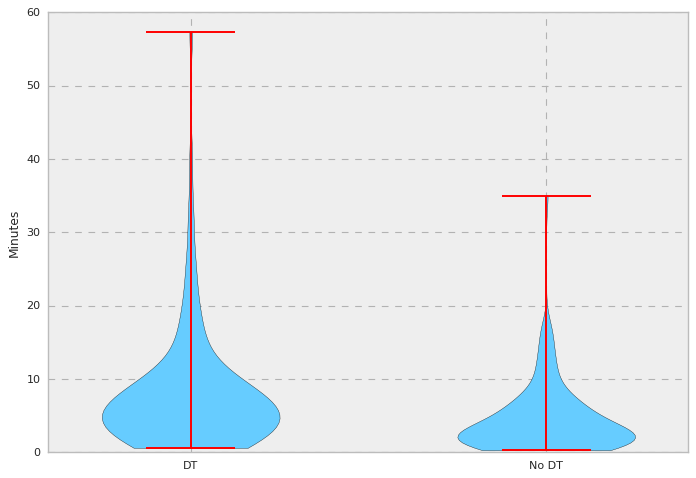

In [82]:

answer_dt = answer_no_dummy[answer_no_dummy.isDt==1]
answer_noDt = answer_no_dummy[answer_no_dummy.isDt==0]

labels = ['DT', 'No DT']

answerDtMinutes = answer_dt.secondsToAnswer/60
answerNoDtMinutes = answer_noDt.secondsToAnswer/60

all_data = [answerDtMinutes.tolist(),answerNoDtMinutes.tolist()]

df_time_required = pd.DataFrame(all_data)
df_time_required = df_time_required.T
df_time_required.columns = labels

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(df_time_required)

import matplotlib.pyplot as plt

## combine these different collections into a list
data_to_plot = all_data

#plt.style.use('bmh')
plt.style.use('seaborn-notebook')
#plt.style.use('fivethirtyeight')
#plt.style.use('seaborn-deep')

# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# Create the violinplot
bp = ax.violinplot(data_to_plot)
for plot in bp['bodies']:
    plot.set_facecolor('#66ccff')
    plot.set_edgecolor('black')
    plot.set_alpha(1)

ax.get_xaxis().set_tick_params(direction='out')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels)
ax.set_xticklabels(labels)
ax.set_ylabel('Minutes')

plt.show()



## Confidence

In [129]:
# pega o dataframe completo de answers equalizado (mesma quantidade de participantes nos dois rows)
answer_no_dummy = answer_no_dummy_overall.copy()

answer_no_dummy.answer_csagreement = abs(answer_no_dummy.answer_csagreement)

answer_dt = answer_no_dummy[answer_no_dummy.isDt==1]
answer_noDt = answer_no_dummy[answer_no_dummy.isDt==0]

labels = ['DT', 'No DT']

sum_dt_strong = sum(answer_dt.answer_csagreement.isin([2,-2]))
sum_dt_slight = sum(answer_dt.answer_csagreement.isin([1,-1]))
sum_noDt_strong = sum(answer_noDt.answer_csagreement.isin([2,-2]))
sum_noDt_slight= sum(answer_noDt.answer_csagreement.isin([1,-1]))

df_confidence = pd.DataFrame([[sum_dt_strong, sum_dt_slight],[sum_noDt_strong, sum_noDt_slight]])
df_confidence.index=labels
df_confidence.columns = ['Strong dis(agreement)','Slight dis(agreement)']


df_confidence



,Strong dis(agreement),Slight dis(agreement)
DT,62,34
No DT,64,32
